# Downstream Fairness

Downstream fairness is an algorithm that looks at the training data distribution, and tries to determine how to perturb the distribution, so that it ascribes to some fairness definition (`TPR`, `FPR`, `EQODDS`). To get more indepth information, here is a link to the original paper: https://arxiv.org/pdf/2203.07490.pdf

The algorithm does the following:

1. It creates an adjustment table that perturbs the prediction probabilities.

2. It generates a $\lambda$ value that is used to adjust the adjustment table values, so that you can ascribe to certain fairness definitions.

Using the adjustment table and the $\lambda$ value, you can perturb prediction probabilities, so that when you apply the decision threshold of your binary classifier, it will satisy the fairness definition attached to $\lambda$, while also preserving accuracy as optimally as possible.

In [15]:
from downstream_fairness.process import get_bias_mitigator, get_adjusted_scores, get_adjustments
from downstream_fairness.utils.metrics import calculate_group_disparity
from demo_helper.data import get_data
from visualizations import visualize_all_results

## Generating example data from a model

The following code gives example data that has been predicted on. The format the data is in is all that is necessary for the downstream fairness algorithm. As you can see (after running the cells below), all the algorithm needs are the groups, the label, and the score.

In [2]:
data = get_data('adult_new', 42, False)

In [3]:
data.label = data.label.astype(int)

In [4]:
data.head()

,score,group,label,group_multi
0,0.00,0,1,6
1,0.54,1,0,1
2,0.45,1,0,1
3,0.63,0,0,6
4,0.00,0,0,2


## The primary function for downstream fairness

`get_bias_mitigator` is the primary "run" function for downstream fairness. Once you have provided the data + the column names for the necessary columns, the downstream fairness algorithm will do all the work to find the lambda and the adjust table.

In [5]:
table, lambdas = get_bias_mitigator(data, sens_col='group_multi', score_col='score', label_col='label')

Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 3434.0              
0.01148834430986    0.01148834430987    0.01148834430987    0.988513185989   0.01148834430986    234.9933806014      
0.009777905459668   0.009777905459668   0.009777905459669   0.1617110754556  0.009777905459667   17.73505290041      
0.007232022673627   0.007232022673627   0.007232022673628   0.2706963973449  0.007232022673627   5.835422080658      
0.004933059891909   0.004933059891909   0.004933059891909   0.3361558471362  0.004933059891908   2.006169850534      
0.004003476928731   0.004003476928731   0.004003476928732   0.2039173096457  0.004003476928731   1.240008985417      
0.003242528037438   0.003242528037438   0.003242528037439   0.2081081773755  0.003242528037438   0.8166158443557     
0.002051873995374   0.002051873995374   0.002051873995374

In [6]:
table

,pred_orig,repaired_scores_1,adjusted_scores_1,repaired_scores_2,adjusted_scores_2,repaired_scores_3,adjusted_scores_3,repaired_scores_4,adjusted_scores_4,repaired_scores_5,adjusted_scores_5,repaired_scores_6,adjusted_scores_6,repaired_scores_7,adjusted_scores_7,repaired_scores_8,adjusted_scores_8,repaired_scores_9,adjusted_scores_9
0,0.00,0.01,0.01,0.01,0.01,0.02,0.02,0.0,0.00,0.03,0.03,0.00,0.00,0.01,0.01,0.01,0.01,0.04,0.04
1,0.01,0.02,0.01,0.03,0.02,0.04,0.03,0.0,-0.01,0.05,0.04,0.01,0.00,0.02,0.01,0.03,0.02,0.07,0.06
2,0.02,0.03,0.01,0.05,0.03,0.05,0.03,0.0,-0.02,0.08,0.06,0.02,0.00,0.05,0.03,0.04,0.02,0.10,0.08
3,0.03,0.03,0.00,0.08,0.05,0.05,0.02,0.0,-0.03,0.23,0.20,0.02,-0.01,0.05,0.02,0.07,0.04,0.11,0.08
4,0.04,0.04,0.00,0.10,0.06,0.07,0.03,0.0,-0.04,0.23,0.19,0.03,-0.01,0.09,0.05,0.10,0.06,0.14,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.96,0.97,0.01,1.00,0.04,0.99,0.03,1.0,0.04,0.98,0.02,0.95,-0.01,1.00,0.04,1.00,0.04,0.99,0.03
97,0.97,0.98,0.01,1.00,0.03,0.99,0.02,1.0,0.03,0.98,0.01,0.97,0.00,1.00,0.03,1.00,0.03,0.99,0.02
98,0.98,0.99,0.01,1.00,0.02,0.99,0.01,1.0,0.02,1.00,0.02,0.98,0.00,1.00,0.02,1.00,0.02,1.00,0.02
99,0.99,1.00,0.01,1.00,0.01,1.00,0.01,1.0,0.01,1.00,0.01,0.99,0.00,1.00,0.01,1.00,0.01,1.00,0.01


In [7]:
lambdas

{'eqodds': 0.48, 'fpr': 0.59, 'tpr': 0.48}

## Checking out the results

Below, we are able to see that the group disparities have decreased. This is signified by the fact that the difference between the original disparity per group (which is when $\lambda = 0$) and the new disparity per group is positive.

Moreover, if you look at the graphs below, you can see that, for a specific metric, the groups all have more similar metrics across metric definitions and thresholds, while not losing much, if any accuracy.

In [12]:
disparities = {}
for key, value in lambdas.items():
    for group in list(set(data.group_multi)):
        # Starting to construct the experiment
        helper_dataset = data.rename(columns={'score': 'old_score'}, inplace=False)
        disparities[key + '_before_after_difference' + str(group)] = calculate_group_disparity(group, 
                                                                               helper_dataset, 
                                                                               key,
                                                                               'group_multi',
                                                                               'label',
                                                                               lam=0) - calculate_group_disparity(group, 
                                                                                                              helper_dataset, 
                                                                                                              key,
                                                                                                              'group_multi',
                                                                                                              'label', 
                                                                                                              lam=value)

In [13]:
disparities

{'eqodds_before_after_difference1': 0.3005445544554455,
 'eqodds_before_after_difference2': 0.22777227722772275,
 'eqodds_before_after_difference3': 0.18029702970297024,
 'eqodds_before_after_difference4': 0.5041089108910892,
 'eqodds_before_after_difference5': 0.37534653465346546,
 'eqodds_before_after_difference6': 0.38252475247524753,
 'eqodds_before_after_difference7': 0.10188118811881186,
 'eqodds_before_after_difference8': 0.4071782178217823,
 'eqodds_before_after_difference9': 0.23836633663366324,
 'fpr_before_after_difference1': 0.20009900990099005,
 'fpr_before_after_difference2': 0.19158415841584142,
 'fpr_before_after_difference3': 0.20415841584158412,
 'fpr_before_after_difference4': 1.154851485148514,
 'fpr_before_after_difference5': 0.49980198019802,
 'fpr_before_after_difference6': 0.22267326732673265,
 'fpr_before_after_difference7': 0.1080198019801979,
 'fpr_before_after_difference8': 0.20861386138613858,
 'fpr_before_after_difference9': 0.22128712871287126,
 'tpr_befo

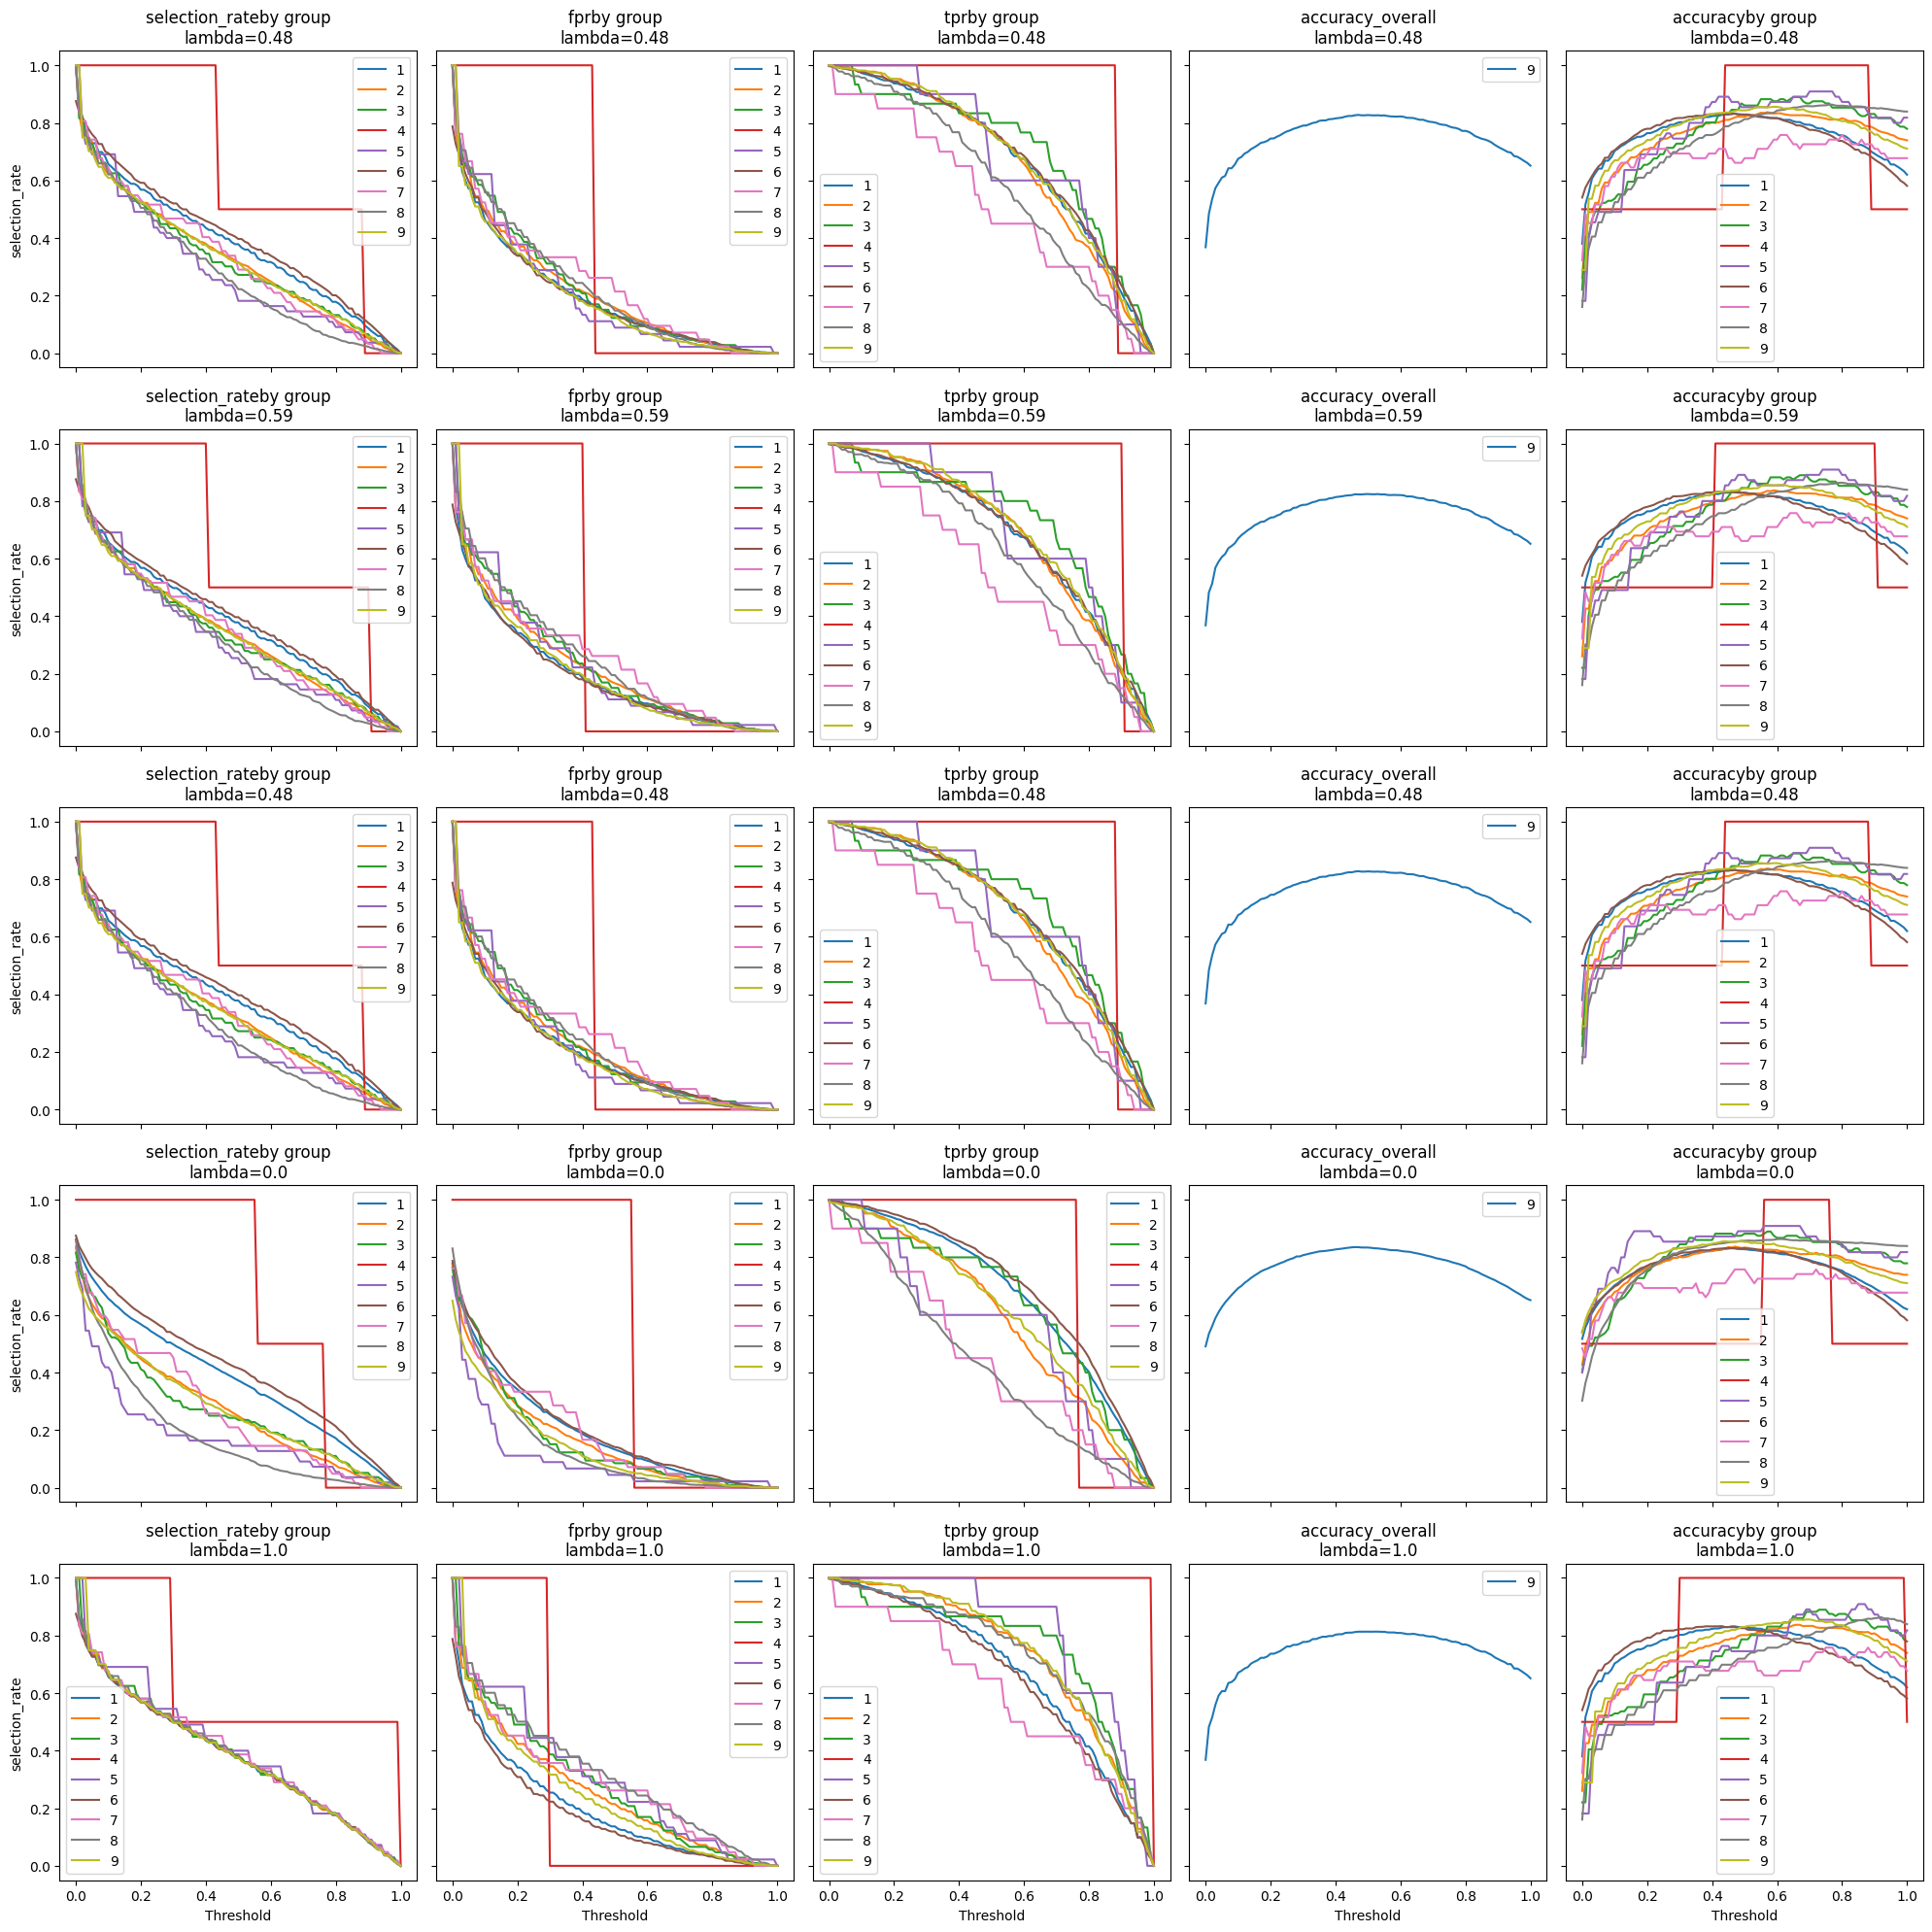

In [10]:
visualize_all_results(data, lambdas, table, sens_col='group_multi', score_col='score', label_col='label')

## Adjusting scores on the fly

Once you are happy with the results of the algorithm, you can also get a new adjustment table that has the lambda values already assigned via `get_adjustments`. If you wanted to adjust data automatically, you can use the `get_adjusted_scores` function.

Notice that both of these output numpy arrays. These arrays contain either adjustments that should be applied to each row of your prediction probabilities or an array that has already adjusted the probabilities, respecitively.

In [19]:
new_adjustments = get_adjustments(table, data, 'group_multi', 'score', lam=lambdas['tpr'])

In [22]:
new_adjustments

array([0.    , 0.    , 0.0048, ..., 0.096 , 0.    , 0.1776])

In [23]:
adjusted_scores = get_adjusted_scores(table, data, 'group_multi', 'score', lam=lambdas['tpr'])

In [24]:
adjusted_scores

array([0.    , 0.54  , 0.4548, ..., 0.196 , 0.85  , 0.6876])